<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [2]:
name = 'LunarLander'
# Read the json info file
with open(f'4-data/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'4-data/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'4-data/{name}_target.parquet')


# Dynamical system

In [3]:
x_size = x_start.shape[1]

# # A pytorch module that multiplies the output of two other modules, where the two modules are given as arguments to the constructor, and the fo
# # The forward method takes a single argument and returns a single tensor.
# class Multiply(nn.Module):
#     def __init__(self, module1, module2):
#         super().__init__()
#         self.module1 = module1
#         self.module2 = module2
#     def forward(self, x):
#         return self.module1(x) * self.module2(x)

# map = Multiply(nn.Linear(x_size, x_size), nn.Linear(x_size, x_size)) 

map = nn.Sequential(nn.Linear(x_size, x_size), nn.LeakyReLU(), nn.Linear(x_size, x_size))

In [4]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

x_start_tensor_test = x_start_tensor[:100]
x_target_tensor_test = x_target_tensor[:100]

x_start_tensor = x_start_tensor[100:]
x_target_tensor = x_target_tensor[100:]
print(x_start_tensor.shape, x_start_tensor_test.shape)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

torch.Size([917, 404]) torch.Size([100, 404])


In [5]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RAdam(map.parameters())

In [6]:
max_epochs = 1000
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.40114688873291016
Epoch 100, Batch 9, Loss 0.00041216914542019367
Epoch 200, Batch 9, Loss 0.00021329874289222062
Epoch 300, Batch 9, Loss 0.00016512410365976393
Epoch 400, Batch 9, Loss 0.000239489134401083
Epoch 500, Batch 9, Loss 0.00015886170149315149
Epoch 600, Batch 9, Loss 7.791195093886927e-05
Epoch 700, Batch 9, Loss 0.00013181718531996012
Epoch 800, Batch 9, Loss 0.00011436011118348688
Epoch 900, Batch 9, Loss 8.591423102188855e-05


In [7]:
x_start_tensor_test.shape

torch.Size([100, 404])

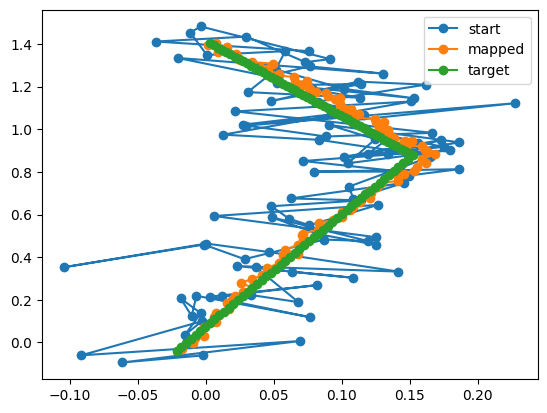

In [8]:
plot_idx = 2
mapped_tensor = map(x_start_tensor).detach()
plt.figure()
plt.plot(x_start_tensor[plot_idx,0:101].numpy(), x_start_tensor[plot_idx,101:202].numpy(), '-o', label='start')
plt.plot(mapped_tensor[plot_idx,0:101].numpy(), mapped_tensor[plot_idx,101:202].numpy(), '-o', label='mapped')
plt.plot(x_target_tensor[plot_idx,0:101].numpy(), x_target_tensor[plot_idx,101:202].numpy(), '-o', label='target')
plt.legend()

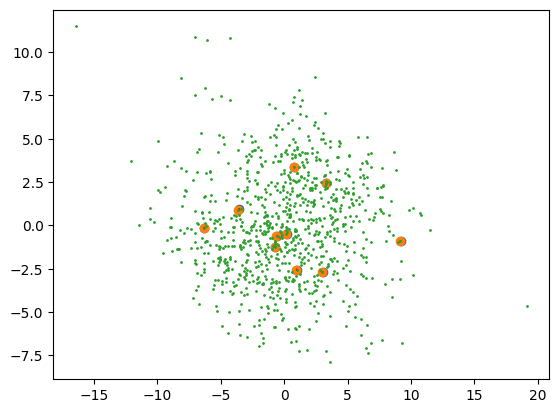

In [9]:
mapped_tensor = map(x_start_tensor).detach()
plot_points = 10

from sklearn.decomposition import PCA

def plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=2)
    pca.fit(x_target_tensor)
    # Project tensors to 2D using PCA
    x_start_tensor_2 = pca.transform(x_start_tensor)[:plot_points]
    mapped_tensor_2 = pca.transform(mapped_tensor)[:plot_points]
    x_target_tensor_2 = pca.transform(x_target_tensor)

    # Plot the 2D PCA projections and arrows
    fig, ax = plt.subplots()
    ax.scatter(x_start_tensor_2[:,0], x_start_tensor_2[:,1])
    ax.scatter(mapped_tensor_2[:,0], mapped_tensor_2[:,1])
    dx = mapped_tensor_2[:,0]-x_start_tensor_2[:,0]
    dy = mapped_tensor_2[:,1]-x_start_tensor_2[:,1]
    ax.quiver(x_start_tensor_2[:,0], x_start_tensor_2[:,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
    ax.scatter(x_target_tensor_2[:,0], x_target_tensor_2[:,1], s=1)
    plt.show()

# Plot the 2D PCA projections and arrows for the three tensors
plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points)

# Testing data

## Testing label

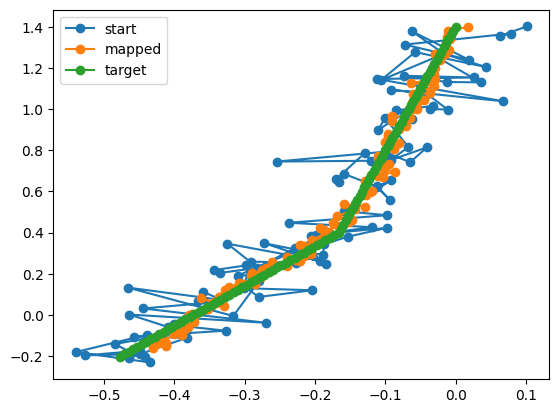

In [10]:
plot_idx = 2
mapped_tensor = map(x_start_tensor_test).detach()
plt.figure()
plt.plot(x_start_tensor_test[plot_idx,0:101].numpy(), x_start_tensor_test[plot_idx,101:202].numpy(), '-o', label='start')
plt.plot(mapped_tensor[plot_idx,0:101].numpy(), mapped_tensor[plot_idx,101:202].numpy(), '-o', label='mapped')
plt.plot(x_target_tensor_test[plot_idx,0:101].numpy(), x_target_tensor_test[plot_idx,101:202].numpy(), '-o', label='target')
plt.legend()

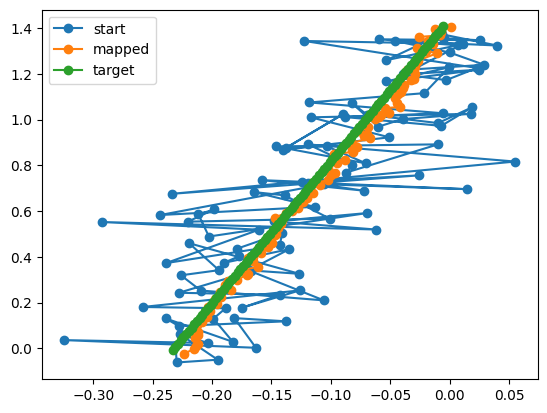

In [11]:
plot_idx = 3
mapped_tensor = map(x_start_tensor_test).detach()
plt.figure()
plt.plot(x_start_tensor_test[plot_idx,0:101].numpy(), x_start_tensor_test[plot_idx,101:202].numpy(), '-o', label='start')
plt.plot(mapped_tensor[plot_idx,0:101].numpy(), mapped_tensor[plot_idx,101:202].numpy(), '-o', label='mapped')
plt.plot(x_target_tensor_test[plot_idx,0:101].numpy(), x_target_tensor_test[plot_idx,101:202].numpy(), '-o', label='target')
plt.legend()